In [1]:
from utils import *
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchinfo import summary
import torch.optim as optim
import torch.nn.init as init
import torch.nn as nn
import numpy as np
import random
import torch
import os

manualSeed = 999 
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True)  
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"runnning on {device}")

Random Seed:  999
runnning on cpu


In [2]:
folders = ["../data"]
for f in folders:
    if not os.path.exists(f):
        os.mkdir(f)
batch_size_train = 64
batch_size_test = 1000
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
)
train_dataset = datasets.MNIST("../data", train=True, download=True, transform=transform)
test_dataset = datasets.MNIST("../data", train=False, transform=transform)
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size_train, shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size_test, shuffle=True
)

100%|██████████| 12/12 [00:00<00:00, 476.48it/s]


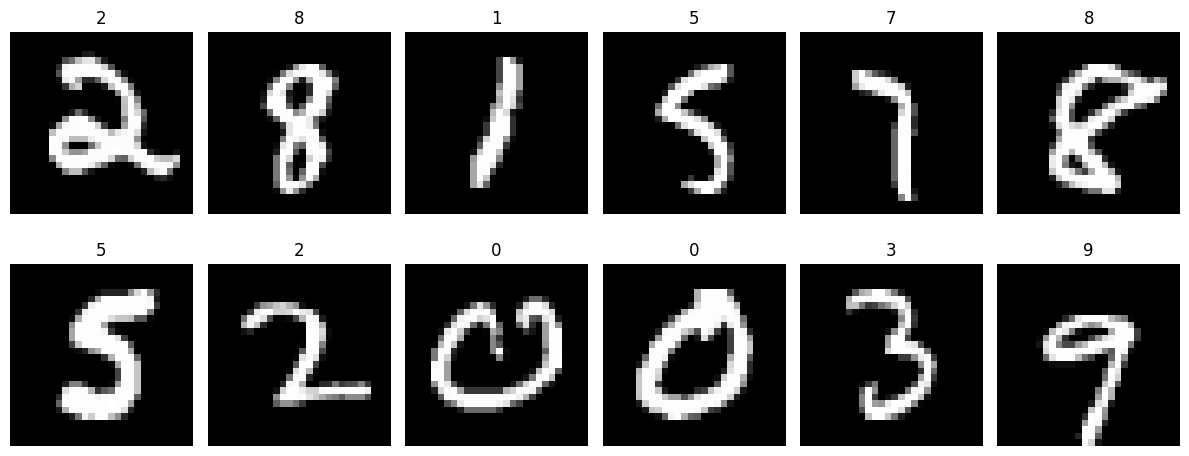

In [3]:
show_images(test_dataset, num_rows=2, num_cols=6)

In [4]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=32,
                kernel_size=3,
                stride=1,
                padding=1,
                bias=True,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout2d(p=0.2),
            nn.Conv2d(
                in_channels=32,
                out_channels=64,
                kernel_size=3,
                stride=1,
                padding=1,
                bias=True,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout2d(p=0.2),
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(in_features=64*7*7, out_features=128, bias=True),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(in_features=128, out_features=10, bias=True),
        )
        # Initialize weights
        self._initialize_weights()

    def forward(self, x):
        x = self.conv_layers(x)
        x = torch.flatten(x, 1)
        x = self.fc_layers(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    init.constant_(m.bias, 0)


model = Net()
input_size = (batch_size_train, 1, 28, 28)
summary(
    model,
    input_size=input_size,
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"],
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
Net (Net)                                [64, 1, 28, 28]      [64, 10]             --                   True
├─Sequential (conv_layers)               [64, 1, 28, 28]      [64, 64, 7, 7]       --                   True
│    └─Conv2d (0)                        [64, 1, 28, 28]      [64, 32, 28, 28]     320                  True
│    └─ReLU (1)                          [64, 32, 28, 28]     [64, 32, 28, 28]     --                   --
│    └─MaxPool2d (2)                     [64, 32, 28, 28]     [64, 32, 14, 14]     --                   --
│    └─Dropout2d (3)                     [64, 32, 14, 14]     [64, 32, 14, 14]     --                   --
│    └─Conv2d (4)                        [64, 32, 14, 14]     [64, 64, 14, 14]     18,496               True
│    └─ReLU (5)                          [64, 64, 14, 14]     [64, 64, 14, 14]     --                   --
│    └─MaxPool2d (6)  

In [5]:
learning_rate = 0.001
n_epochs = 20
train_losses = []
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

Train: model=Net, opt=Adam(lr=0.001), num_epochs=20, device=cpu

Epoch 1/20
	Batch 312/938, loss: 0.3571
	Batch 624/938, loss: 0.2388
	Batch 936/938, loss: 0.1882
Epoch 1/20, train loss: 0.1883, train acc: 0.9417, val loss: 0.0575, val acc: 0.9809

Epoch 2/20
	Batch 312/938, loss: 0.0712
	Batch 624/938, loss: 0.0700
	Batch 936/938, loss: 0.0669
Epoch 2/20, train loss: 0.0670, train acc: 0.9797, val loss: 0.0379, val acc: 0.9866

Epoch 3/20
	Batch 312/938, loss: 0.0544
	Batch 624/938, loss: 0.0509
	Batch 936/938, loss: 0.0503
Epoch 3/20, train loss: 0.0504, train acc: 0.9846, val loss: 0.0287, val acc: 0.9899

Epoch 4/20
	Batch 312/938, loss: 0.0392
	Batch 624/938, loss: 0.0400
	Batch 936/938, loss: 0.0387
Epoch 4/20, train loss: 0.0387, train acc: 0.9878, val loss: 0.0278, val acc: 0.9905

Epoch 5/20
	Batch 312/938, loss: 0.0367
	Batch 624/938, loss: 0.0359
	Batch 936/938, loss: 0.0344
Epoch 5/20, train loss: 0.0345, train acc: 0.9892, val loss: 0.0269, val acc: 0.9902

Epoch 6/20
	Bat

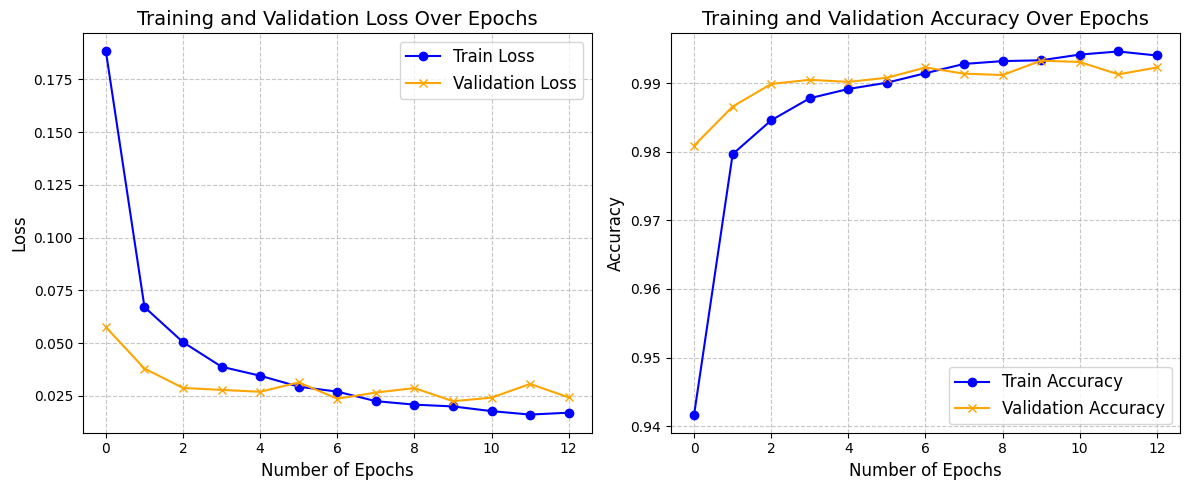

In [6]:
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
early_stopper = EarlyStopper(patience=3, delta=0.001)
model, history = train_classification_model(
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    train_dataloader=train_loader,
    val_dataloader=test_loader,
    num_epochs=n_epochs,
    device=device,
    # scheduler=scheduler,
    early_stopper=early_stopper,
    plot_figs=True,
    nb_batches_to_display=len(train_loader)//3
)

In [7]:
evaluate_model(model=model, test_loader=test_loader, device=device)

100%|██████████| 10/10 [00:06<00:00,  1.67it/s]

Accuracy on test set: 0.99230


In [8]:
misclassified_samples = get_misclassified_samples(model=model, test_loader=test_loader, device=device)
print("Number of misclassified samples", len(misclassified_samples.dataset))

100%|██████████| 10/10 [00:06<00:00,  1.67it/s]

Number of misclassified samples 77


100%|██████████| 24/24 [00:00<00:00, 744.88it/s]


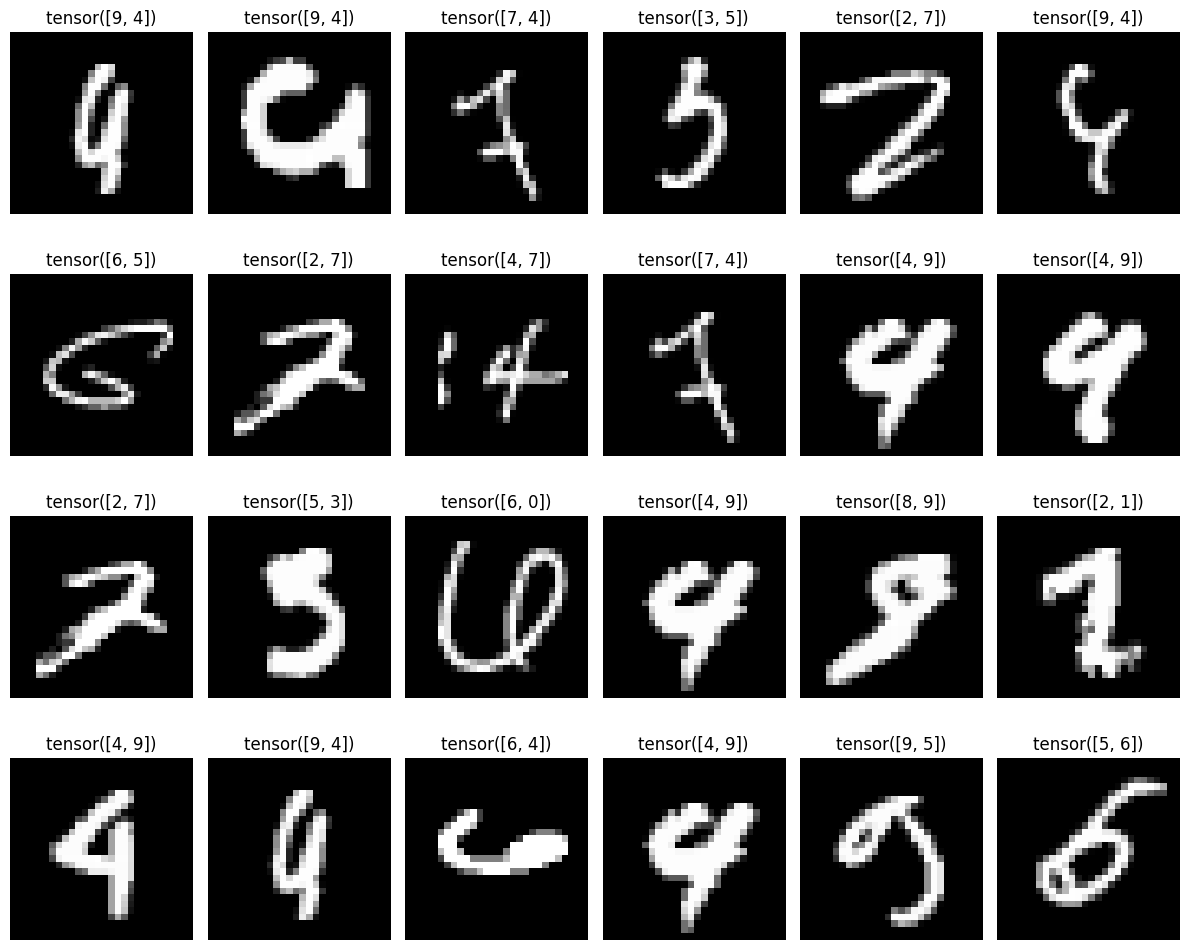

In [9]:
show_images(misclassified_samples.dataset, num_rows=4, num_cols=6)

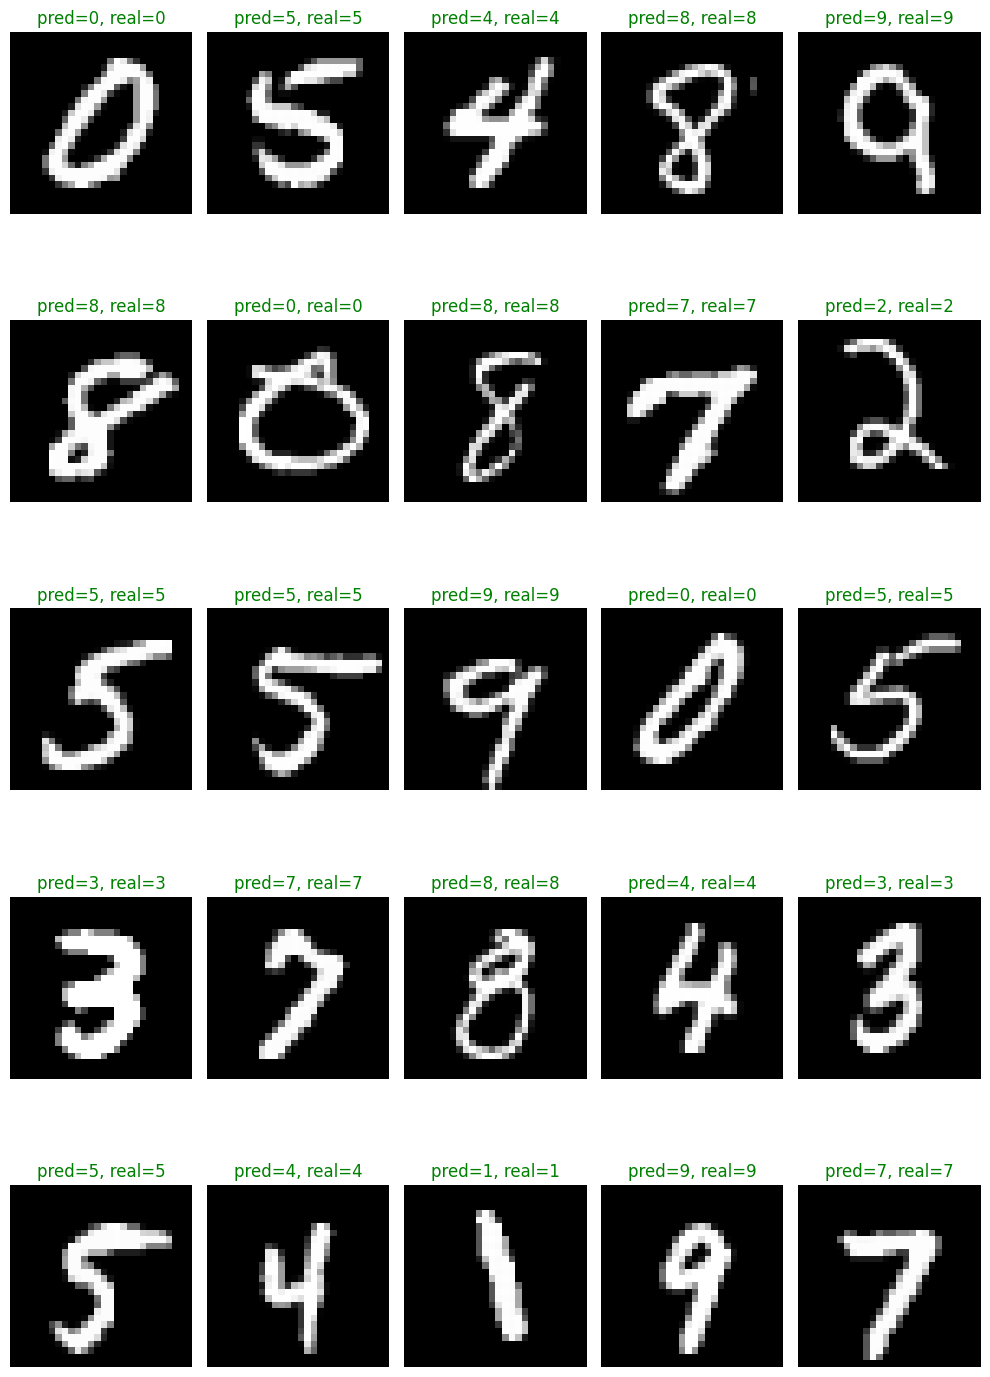

In [10]:
batch_idx, (example_data, example_targets) = next(enumerate(test_loader))
with torch.no_grad():
    output = model(example_data)  
    fig, axes = plt.subplots(5, 5, figsize=(10, 15))  
    predictions = output.argmax(dim=1)  
    for i, ax in enumerate(axes.flat):
        ax.imshow(example_data[i][0], cmap="gray", interpolation="none")
        prediction = predictions[i].item()
        target = example_targets[i].item()
        ax.set_title(f"pred={prediction}, real={target}", color='green' if prediction == target else 'red')
        ax.axis('off')  

    plt.tight_layout()  
    plt.show()